In [1]:
#数据预处理
%matplotlib inline
import tensorflow as tf
import numpy as np
import os
from time import time
from scipy.signal import welch
from scipy.interpolate import  interp1d as interp
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import scale
from sklearn.model_selection import StratifiedKFold 
from tensorflow.keras.utils import Progbar
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
class Preprocessing(object):
    """
    对序列进行提取特征等预处理
    为了可能处理变长序列,因此输入为list
    """
    def __init__(self,with_label=True):
        self.with_label=with_label
    def __call__(self,sequence):
        for i in range(len(sequence)):
            time_point=np.expand_dims(sequence[i][0],axis=0)
            if self.with_label:
                label=np.expand_dims(sequence[i][-1],axis=0)
                new_sequence=self.for_each(sequence[i][1:-1])
                sequence[i]=np.concatenate([time_point,new_sequence,label],axis=0)
            else:
                new_sequence=self.for_each(sequence[i][1:])
                sequence[i]=np.concatenate([time_point,new_sequence],axis=0)
        sequence=self.for_all(sequence)
        return sequence
    def smooth(self,array,decay_rate=0.9):
        _smooth=np.zeros(array.shape)
        for i in range(1,len(array)-1):
            decay=min(decay_rate,(i+1)/(i+10))
            _smooth[i]=_smooth[i-1]*decay+(1-decay)*array[i]
        return _smooth
    def for_all(self,sequence):#变长序列可以numpy吗#
        return sequence
        mean=np.zeros(shape=sequence[0].shape[0])
        std=np.zeros(shape=sequence[0].shape[0])
        lenth=len(sequence)
        for index in range(lenth):
            if self.with_label:
                _range=range(1,sequence[index].shape[0]-1)
            else:
                _range=range(1,sequence[index].shape[0])
            for i in _range:
                mean[i]+=sequence[index][i].mean()/lenth
                std[i]+=sequence[index][i].std()/lenth
        for index in range(lenth):
            if self.with_label:
                _range=range(1,sequence[index].shape[0]-1)
            else:
                _range=range(1,sequence[index].shape[0])
            for i in _range:
                sequence[index][i]=(sequence[index][i]-mean[i])/std[i]
        return sequence
    def for_each(self,sequence):
        acc=(sequence[0]**2+sequence[1]**2+sequence[2]**2)**0.5
        acc=np.expand_dims(acc,axis=0)
        acc_g=(sequence[3]**2+sequence[4]**2+sequence[5]**2)**0.5
        acc_g=np.expand_dims(acc_g,axis=0)
        sequence=np.concatenate([sequence,acc,acc_g],axis=0)
        return sequence[::,::-1]

In [2]:
#加载数据
class DatasetLoader(object):
    def __init__(self,csv_file,with_label=True,num_classes=19):
        self.csv_file=csv_file
        self.with_label=with_label
        self.format="channel_last"
        self.split=False
        self.names=self.get_feature_names()
        self.num_classes=num_classes
        self.data_split=False
    def get_feature_names(self):
         with open(self.csv_file) as f:
            examples={}
            names=f.readline().split(',')[1:]
            names[-1]=names[-1][:-1]
            return names
    def make_numpy(self,num_interpolation=200,with_label=True):
        '''将数据读取并保存为Numpy数组
               Args:
                 num_interpolation:差值法采样点个数
                 with_label：是否带标签
               Returns:
                 A list,shape=[num_examples,keys,length]
        '''
        #数据读取
        if self.csv_file is None:
            raise ValueError("sub dataset cannnot get numpy data")
        print("Loading date...")
        line={}
        with open(self.csv_file) as f:
            examples={}
            names=f.readline().split(',')[1:]
            names[-1]=names[-1][:-1]
            while True:
                try:
                    line=f.readline().split(",")
                    if line is None:
                        break
                    for i in range(len(line)):
                        line[i]=eval(line[i])
                    if not line[0] in examples:
                        examples[line[0]]=[]
                    examples[line[0]].append(line[1:])
                except:
                    break
        print("done")
        #格式转换            
        for i in range(len(examples)):
            examples[i]=np.array(examples[i]).transpose([1,0])
        self.examples=examples=list(examples.values())
        return self
    def resample(self,num_interpolation=200):
        examples=self.examples
        print("interpolate")
        bar=Progbar(len(examples))#进度条
        if num_interpolation and num_interpolation is not None:
            for i in range(len(examples)):
                range_len=examples[i][0][-1]-examples[i][0][0]
                range_start=examples[i][0][0]
                range_interval=range_len/num_interpolation
                interp_x=[range_start+range_interval*i for i in range(num_interpolation)]
                interp_data=[interp_x]
                for feature_id in range(1,len(self.names)):
                    try:
                        interp_f=interp(examples[i][0],examples[i][feature_id],kind="cubic")
                        interp_data.append([interp_f(x)for x in interp_x])
                    except:
                        raise ValueError("%d %d"%(i,feature_id),examples[i])
                bar.update(i)
                examples[i]=np.array(interp_data)
        print("\ndone")
        #数据预处理
        preprocession=Preprocessing(with_label=self.with_label)
        examples=preprocession(examples)
        self.examples=np.array(examples,dtype="float32")    
        if self.with_label:
            self.y=self.examples[::,-1,0].tolist()
            self.x=self.examples[::,1:-1,::]
        else:
            self.x=self.examples[::,1:,::]
        return self
    def apply_class_weights(self):
        weights=np.zeros([self.num_classes])
        for i in range(len(weights)):
            weights[i]=(self.examples[::,-1:,0]==i).sum()
        return weights/weights.sum()
    def data_format(string="channel_last"):
        if not string in ["channel_first","channel_last"]:
            raise ValueError("either channel_last or channel_first are supported")
        self.format=string
    def apply_data(self):
        if self.with_label:
            if self.split:
                if self.format=="channel_first":
                    return self.x_train,self.y_train,self.x_test,self.y_test
                else:
                    return self.x_train.transpose([0,2,1]),self.y_train,self.x_test.transpose([0,2,1]),self.y_test
                    
            else:
                if self.format=="channel_first":
                    return self.x,self.y
                else:
                    return self.x.transpose([0,2,1]),self.y
        else:
            if self.format=="channel_first":
                return self.x
            else:
                return self.x.transpose([0,2,1])
class DataGenerator(object):
    def __init__(self,x,y,batch_size,random_shuffle=False,windows=None,num_classes=None):
        self.x=x
        self.random_shuffle=random_shuffle
        self.batch_size=batch_size
        self.windows=windows
        try:
            self.y=y
            self.num_examples,self.num_classes=self.num_classes=y.shape
        except:
            self.y=y
            self.num_examples=len(y)
            self.num_classes=num_classes
            self.y=to_categorical(y,num_classes)
        self.counter=0
    def mixup(self,x1,x2,y1,y2):
        ratio=np.random.randint(0,65536)/65536
        x=x1*ratio+x2*(1-ratio)
        y=y1*ratio+y2*(1-ratio)
        return x,y
    def random_crop(self,x,lenth):
        start=np.random.randint(0,x.shape[0]-lenth)
        end=start+lenth
        return x[start:end]
    def pop(self,random_shuffle):
        x,y=self.x[self.counter],self.y[self.counter]
        self.counter=self.counter+1
        if self.counter>=self.num_examples:
            self.counter=0
            if random_shuffle:
                self.x,self.y=shuffle(self.x,self.y)
        return x,y
    def __len__(self):
        return round(self.num_examples/self.batch_size)
    def __call__(self):
        if self.random_shuffle:
            self.x,self.y=shuffle(self.x,self.y)
        shape=list(self.x.shape)
        shape[0]=self.batch_size
        if self.windows is not None:
            shape[1]=self.windows
        x_batch=np.zeros(shape)
        y_batch=np.zeros([self.batch_size,self.num_classes])
        while True:
            for i in range(self.batch_size):
                x,y=self.pop(self.random_shuffle)
                if self.windows is not None:
                    x=self.random_crop(x,self.windows)
                x_batch[i],y_batch[i]=x,y
            yield x_batch,y_batch

In [3]:
#metrics
import tensorflow as tf
import tensorflow.keras.backend as K
import numpy as np
def single_score(y, y_pred):
    # 数值ID与行为编码的对应关系
    mapping = {0: 'A_0', 1: 'A_1', 2: 'A_2', 3: 'A_3', 
        4: 'D_4', 5: 'A_5', 6: 'B_1',7: 'B_5', 
        8: 'B_2', 9: 'B_3', 10: 'B_0', 11: 'A_6', 
        12: 'C_1', 13: 'C_3', 14: 'C_0', 15: 'B_6', 
        16: 'C_2', 17: 'C_5', 18: 'C_6'}
    # 将行为ID转为编码
    code_y, code_y_pred = mapping[y], mapping[y_pred]
    if code_y == code_y_pred: #编码完全相同得分1.0
        return 1.0
    elif code_y.split("_")[0] == code_y_pred.split("_")[0]: #编码仅字母部分相同得分1.0/7
        return 1.0/7
    elif code_y.split("_")[1] == code_y_pred.split("_")[1]: #编码仅数字部分相同得分1.0/3
        return 1.0/3
    else:
        return 0.0
def py_score(y_true,y_pred):
    y_true=np.argmax(y_true,axis=-1)
    y_pred=np.argmax(y_pred,axis=-1)
    scores=[]
    for i in range(len(y_true)):
        scores.append(single_score(y_true[i],y_pred[i]))
    mean_score=np.array(scores,dtype="float32").mean()
    return mean_score,mean_score
def score(y_true,y_pred):
    """线上评测所使用的评测方法
    Args:
      y_true:one_hot编码的标签
      y_pred:网络类别置信度预测
    Returns:
      Tensor标量
    """
    mean_score=tf.py_func(py_score,[y_true,y_pred],[tf.float32,tf.float32])[0]
    return tf.reshape(mean_score,shape=())

In [4]:
#网络结构
import tensorflow as tf
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import GlobalAveragePooling1D
from tensorflow.keras.layers import AveragePooling1D
from tensorflow.keras.layers import GlobalMaxPooling1D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import UpSampling1D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Softmax
from tensorflow.keras.layers import Activation
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Embedding
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from extend import AdamW,WeightDecayScheduler
tf.reset_default_graph()
class SoftThreshold(tf.keras.layers.Layer):
    def __init__(self,**kwargs):
        super(SoftThreshold,self).__init__(**kwargs)
    def call(self,inputs):
        tensor=inputs[0]
        threshold=inputs[0]*inputs[1]
        threshold=tf.abs(threshold)
        less=tf.cast(tf.less(tensor,-threshold),tf.float32)
        greater=tf.cast(tf.greater(tensor,threshold),tf.float32)
        tensor=(tensor-threshold)*greater+(tensor+threshold)*less
        return tensor
class SKNet(object):
    def __init__(self,filters,kernel_size,activation,dilation_rates=[1,1,1,1]):
        self.filters=filters
        self.kernel_size=kernel_size
        self.dilation_rates=dilation_rates
        self.activation=activation
        self.squeeze_rate=4
    def branch(self,tensor,dilation_rate):
        x=Conv1D(self.filters,self.kernel_size,1,padding="same",kernel_regularizer=l2(0.00),
                 activation=self.activation,dilation_rate=1)(tensor)
        x=BatchNormalization()(x)
        x=Activation(None)(x)
        return x
    def pool(self,tensor):
        tensor=Conv1D(self.filters,1,1,padding="same",activation=self.activation,kernel_regularizer=l2(0.00))(tensor)
        shape=tensor.shape.as_list()#[batch,lenth,channels]
        scaler=AveragePooling1D(tensor.shape.as_list()[1])(tensor)#[batch,channels]
        scaler=UpSampling1D(shape[1])(scaler)
        return scaler
    def attention(self,tensors):#时间维度上
        for i in range(len(tensors)):
            tensors[i]=tf.transpose(tensors[i],[0,2,1])
        tensor=tf.keras.layers.add(tensors)
        x=GlobalAveragePooling1D()(tensor)
        
        channels=x.shape.as_list()[-1]
        x=Dense(channels//self.squeeze_rate,activation=tf.nn.relu)(x)
        x=Dense(channels,activation=tf.nn.softmax)(x)
        
        x=tf.expand_dims(x,axis=1)
        output=[]
        for i in range(len(tensors)):
            output.append(tf.transpose(SoftThreshold()([tensors[i],x]),[0,2,1]))
        return output
    def __call__(self,tensor):
        x=Conv1D(self.filters,1,1,padding="same",activation=self.activation,kernel_regularizer=l2(0.00))(tensor)
        output=[x]
        output.append(self.pool(tensor))
        for rate in self.dilation_rates:
            output.append(self.branch(tensor,rate))
        output=self.attention(output)
        output=tf.keras.layers.add(output)
        output=Conv1D(self.filters,3,1,padding="same",kernel_regularizer=l2(0.00))(output)
        output=BatchNormalization()(output)
        output=Activation(self.activation)(output)
        return output
    
def CNN(inputs,num_classes):
    x=Conv1D(64,3,1,padding="same",kernel_regularizer=l2(0.00))(inputs)
    x=BatchNormalization()(x)
    x=Activation(tf.nn.relu)(x)
    
    x=Conv1D(128,3,1,padding="same",kernel_regularizer=l2(0.00))(x)
    x=BatchNormalization()(x)
    x=Activation(tf.nn.relu)(x)
    
    x=Conv1D(196,3,1,padding="same",kernel_regularizer=l2(0.00))(x)
    x=BatchNormalization()(x)
    x=Activation(tf.nn.relu)(x)
    
    x=MaxPooling1D(2,padding="same")(x)
    x=Dropout(0.5)(x)
    
    x=Conv1D(256,3,1,padding="same",kernel_regularizer=l2(0.00))(x)
    x=BatchNormalization()(x)
    x=Activation(tf.nn.relu)(x)
    x=Dropout(0.5)(x)
    
    x=SKNet(384,3,activation=tf.nn.relu)(x)
    
    x=GlobalAveragePooling1D()(x)
    x=Dropout(0.5)(x)

    x=Dense(num_classes,kernel_regularizer=l2(0.00))(x)
    x=BatchNormalization()(x)
    x=Softmax()(x)
    return x
#inputs=Input(shape=[200,8])
#outputs=CNN(inputs,num_classes=19)
#tf.keras.utils.plot_model(Model(inputs,outputs))

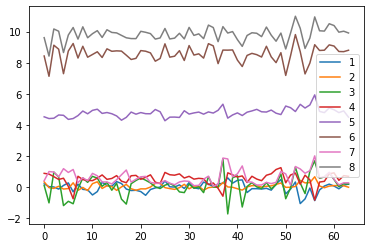

In [5]:
#加载数据和模型
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
tf.reset_default_graph()
csv_file="data\\sensor_train.csv"
test_csv_file="data\\sensor_test.csv"
filepath='best_weights_aspp_raw'
batch_size=128
config=tf.ConfigProto()
config.gpu_options.allow_growth=True   #不全部占满显存, 按需分配
sess=tf.Session(config=config)
K.set_session(sess)
if True:
    dataset=DatasetLoader(csv_file,with_label=True,num_classes=19)
    dataset=dataset.make_numpy()
    dataset=dataset.resample(num_interpolation=64)
    x,y=dataset.apply_data()
    class_weight=dataset.apply_class_weights()
    dataset=DatasetLoader(test_csv_file,with_label=False)
    data=dataset.make_numpy()
    data=dataset.resample(num_interpolation=64)
    x_val=data.apply_data()
#    np.save("data_x_val",x_val)
#    np.save("data_x",x)
#    np.save("data_y",y)
#    np.save("class_weight",class_weight)
#x=np.load("data_x.npy")
#y=np.load("data_y.npy")
#x_val=np.load("data_x_val.npy")
#class_weight=np.load("class_weight.npy")
#plt.plot(x[5])
#plt.legend(["1","2","3","4","5","6","7","8"])
#plt.show()

In [58]:
from tensorflow.keras.utils import to_categorical
config=tf.ConfigProto()
config.gpu_options.allow_growth=True   #不全部占满显存, 按需分配
sess=tf.Session(config=config)
K.set_session(sess)
kfold = StratifiedKFold(5, shuffle=True,random_state=20001026)
proba_t = np.zeros((7500, 19))
proba_x = np.zeros((7292, 19))
train_score=[]
test_score=[]
for fold,(xx,yy) in enumerate(kfold.split(x,y)):
    tf.reset_default_graph()
    inputs=Input(shape=[64,8])
    outputs=CNN(inputs,num_classes=19)
    model=Model(inputs=inputs,outputs=outputs)
    _y=to_categorical(y,19)
    plateau = ReduceLROnPlateau(monitor="val_score",
                                verbose=1,
                                mode='max',
                                factor=0.8,
                                patience=10)
    early_stopping = EarlyStopping(monitor='val_score',
                                   verbose=1,
                                   mode='max',
                                   patience=65)
    checkpoint = ModelCheckpoint(f'fold{fold}.h5',
                                 monitor='val_score',
                                 verbose=1,
                                 mode='max',
                                 save_best_only=True)
    model.compile(loss="categorical_crossentropy",optimizer=AdamW(lr=0.001,weight_decay=6e-4),metrics=["acc",score])
    weight_decay=WeightDecayScheduler(init_lr=0.001)
    x_noisy1=x[xx]+np.random.normal(0,0.05,x[xx].shape)
    x_train=np.concatenate([x[xx],x_noisy1],axis=0)
    y_train=np.concatenate([_y[xx],_y[xx]],axis=0)
    print(x_train.shape)
    trained_model=model.fit(
            x_train,
            y_train,
            batch_size=batch_size,
            class_weight=(1-class_weight)**2,
            shuffle=True,
            validation_data=(x[yy],_y[yy]),
            epochs=800,
            callbacks=[plateau,early_stopping,checkpoint,weight_decay])
    model.load_weights(f'fold{fold}.h5')
    proba_t+=model.predict(x_val,verbose=0,batch_size=256)/ 5.
    proba_x+=model.predict(x,verbose=0,batch_size=256)/5.
    train_score.append(np.array(trained_model.history["score"]).max())
    test_score.append(np.array(trained_model.history["val_score"]).max())
label_t=proba_t.argmax(axis=1)
label_x=proba_x.argmax(axis=1)
print("on_train_set:",np.array(train_score))
print("average:",np.array(train_score).mean())
print("on_test_set:",np.array(test_score))
print("average:",np.array(test_score).mean())
print("done")

(11650, 64, 8)
Train on 11650 samples, validate on 1467 samples
0 1.0000000474974513
Epoch 1/800
11648/11650 [============================>.] - ETA: 0s - loss: 2.0625 - acc: 0.3455 - score: 0.4254
Epoch 00001: val_score improved from -inf to 0.13256, saving model to fold0.h5
11650/11650 [==============================] - 6s 506us/sample - loss: 2.0626 - acc: 0.3454 - score: 0.4216 - val_loss: 3.5872 - val_acc: 0.0648 - val_score: 0.1326
Epoch 2/800
11648/11650 [============================>.] - ETA: 0s - loss: 1.7243 - acc: 0.4700 - score: 0.5402
Epoch 00002: val_score improved from 0.13256 to 0.16418, saving model to fold0.h5
11650/11650 [==============================] - 3s 299us/sample - loss: 1.7244 - acc: 0.4700 - score: 0.5398 - val_loss: 3.1874 - val_acc: 0.0913 - val_score: 0.1642
Epoch 3/800
11520/11650 [============================>.] - ETA: 0s - loss: 1.5908 - acc: 0.5230 - score: 0.5887
Epoch 00003: val_score improved from 0.16418 to 0.18787, saving model to fold0.h5
11650/

11648/11650 [============================>.] - ETA: 0s - loss: 0.6991 - acc: 0.8536 - score: 0.8764
Epoch 00048: val_score did not improve from 0.65098
11650/11650 [==============================] - 4s 316us/sample - loss: 0.6994 - acc: 0.8535 - score: 0.8705 - val_loss: 2.5685 - val_acc: 0.3872 - val_score: 0.4597
Epoch 49/800
11648/11650 [============================>.] - ETA: 0s - loss: 0.7620 - acc: 0.8251 - score: 0.8528
Epoch 00049: val_score did not improve from 0.65098
11650/11650 [==============================] - 4s 319us/sample - loss: 0.7622 - acc: 0.8250 - score: 0.8454 - val_loss: 2.5916 - val_acc: 0.3667 - val_score: 0.4332
Epoch 50/800
11648/11650 [============================>.] - ETA: 0s - loss: 0.6819 - acc: 0.8578 - score: 0.8794
Epoch 00050: val_score did not improve from 0.65098
11650/11650 [==============================] - 4s 318us/sample - loss: 0.6822 - acc: 0.8577 - score: 0.8706 - val_loss: 1.8029 - val_acc: 0.5051 - val_score: 0.5774
Epoch 51/800
11520/1165

11520/11650 [============================>.] - ETA: 0s - loss: 0.4511 - acc: 0.9389 - score: 0.9490
Epoch 00096: val_score did not improve from 0.77450
11650/11650 [==============================] - 4s 311us/sample - loss: 0.4511 - acc: 0.9389 - score: 0.9460 - val_loss: 1.6160 - val_acc: 0.5576 - val_score: 0.6135
Epoch 97/800
11648/11650 [============================>.] - ETA: 0s - loss: 0.4561 - acc: 0.9380 - score: 0.9483
Epoch 00097: val_score did not improve from 0.77450
11650/11650 [==============================] - 4s 314us/sample - loss: 0.4564 - acc: 0.9379 - score: 0.9398 - val_loss: 0.9420 - val_acc: 0.7314 - val_score: 0.7687
Epoch 98/800
11520/11650 [============================>.] - ETA: 0s - loss: 0.4482 - acc: 0.9423 - score: 0.9514
Epoch 00098: val_score did not improve from 0.77450
11650/11650 [==============================] - 4s 310us/sample - loss: 0.4495 - acc: 0.9418 - score: 0.9470 - val_loss: 1.3603 - val_acc: 0.6217 - val_score: 0.6685
Epoch 99/800
11648/1165

119 0.8
Epoch 120/800
11648/11650 [============================>.] - ETA: 0s - loss: 0.3891 - acc: 0.9595 - score: 0.9664
Epoch 00120: val_score did not improve from 0.80237
11650/11650 [==============================] - 4s 314us/sample - loss: 0.3895 - acc: 0.9593 - score: 0.9574 - val_loss: 0.9046 - val_acc: 0.7491 - val_score: 0.7895
Epoch 121/800
11648/11650 [============================>.] - ETA: 0s - loss: 0.3799 - acc: 0.9600 - score: 0.9667
Epoch 00121: val_score did not improve from 0.80237
11650/11650 [==============================] - 4s 311us/sample - loss: 0.3802 - acc: 0.9599 - score: 0.9617 - val_loss: 1.0313 - val_acc: 0.7069 - val_score: 0.7574
Epoch 122/800
11520/11650 [============================>.] - ETA: 0s - loss: 0.3844 - acc: 0.9582 - score: 0.9648
Epoch 00122: val_score did not improve from 0.80237
11650/11650 [==============================] - 4s 323us/sample - loss: 0.3845 - acc: 0.9582 - score: 0.9599 - val_loss: 1.5592 - val_acc: 0.5855 - val_score: 0.6410

11520/11650 [============================>.] - ETA: 0s - loss: 0.3366 - acc: 0.9710 - score: 0.9758
Epoch 00168: val_score did not improve from 0.83661
11650/11650 [==============================] - 4s 316us/sample - loss: 0.3373 - acc: 0.9708 - score: 0.9688 - val_loss: 0.7381 - val_acc: 0.8037 - val_score: 0.8334
Epoch 169/800
11648/11650 [============================>.] - ETA: 0s - loss: 0.3256 - acc: 0.9752 - score: 0.9793
Epoch 00169: val_score did not improve from 0.83661
11650/11650 [==============================] - 4s 317us/sample - loss: 0.3258 - acc: 0.9751 - score: 0.9759 - val_loss: 0.8406 - val_acc: 0.7689 - val_score: 0.8027
Epoch 170/800
11520/11650 [============================>.] - ETA: 0s - loss: 0.3401 - acc: 0.9711 - score: 0.9758
Epoch 00170: val_score improved from 0.83661 to 0.84814, saving model to fold0.h5
11650/11650 [==============================] - 4s 325us/sample - loss: 0.3415 - acc: 0.9708 - score: 0.9659 - val_loss: 0.6688 - val_acc: 0.8187 - val_score

Epoch 192/800
11520/11650 [============================>.] - ETA: 0s - loss: 0.3115 - acc: 0.9809 - score: 0.9841
Epoch 00192: val_score did not improve from 0.85460
11650/11650 [==============================] - 4s 318us/sample - loss: 0.3117 - acc: 0.9808 - score: 0.9735 - val_loss: 0.6777 - val_acc: 0.8044 - val_score: 0.8357
Epoch 193/800
11520/11650 [============================>.] - ETA: 0s - loss: 0.3073 - acc: 0.9806 - score: 0.9838
Epoch 00193: val_score did not improve from 0.85460
11650/11650 [==============================] - 4s 312us/sample - loss: 0.3074 - acc: 0.9806 - score: 0.9751 - val_loss: 0.7220 - val_acc: 0.7969 - val_score: 0.8263
Epoch 194/800
11648/11650 [============================>.] - ETA: 0s - loss: 0.3129 - acc: 0.9775 - score: 0.9812
Epoch 00194: val_score did not improve from 0.85460
11650/11650 [==============================] - 4s 313us/sample - loss: 0.3132 - acc: 0.9775 - score: 0.9815 - val_loss: 0.6659 - val_acc: 0.8228 - val_score: 0.8509
Epoch 1

11520/11650 [============================>.] - ETA: 0s - loss: 0.2928 - acc: 0.9819 - score: 0.9850
Epoch 00216: val_score did not improve from 0.86799
11650/11650 [==============================] - 4s 314us/sample - loss: 0.2929 - acc: 0.9821 - score: 0.9799 - val_loss: 0.6362 - val_acc: 0.8187 - val_score: 0.8453
Epoch 217/800
11648/11650 [============================>.] - ETA: 0s - loss: 0.2885 - acc: 0.9845 - score: 0.9872
Epoch 00217: val_score did not improve from 0.86799
11650/11650 [==============================] - 4s 313us/sample - loss: 0.2890 - acc: 0.9844 - score: 0.9772 - val_loss: 0.6210 - val_acc: 0.8364 - val_score: 0.8621
Epoch 218/800
11648/11650 [============================>.] - ETA: 0s - loss: 0.2904 - acc: 0.9860 - score: 0.9883
Epoch 00218: val_score did not improve from 0.86799
11650/11650 [==============================] - 4s 313us/sample - loss: 0.2908 - acc: 0.9858 - score: 0.9784 - val_loss: 0.7754 - val_acc: 0.8003 - val_score: 0.8305
Epoch 219/800
11520/1

11648/11650 [============================>.] - ETA: 0s - loss: 0.2877 - acc: 0.9846 - score: 0.9871
Epoch 00264: val_score did not improve from 0.87445
11650/11650 [==============================] - 4s 313us/sample - loss: 0.2882 - acc: 0.9845 - score: 0.9771 - val_loss: 0.5751 - val_acc: 0.8419 - val_score: 0.8693
Epoch 265/800
11520/11650 [============================>.] - ETA: 0s - loss: 0.2725 - acc: 0.9893 - score: 0.9912
Epoch 00265: val_score did not improve from 0.87445
11650/11650 [==============================] - 4s 313us/sample - loss: 0.2727 - acc: 0.9892 - score: 0.9830 - val_loss: 0.5769 - val_acc: 0.8446 - val_score: 0.8705
Epoch 266/800
11520/11650 [============================>.] - ETA: 0s - loss: 0.2796 - acc: 0.9865 - score: 0.9888
Epoch 00266: val_score did not improve from 0.87445
11650/11650 [==============================] - 4s 326us/sample - loss: 0.2799 - acc: 0.9865 - score: 0.9835 - val_loss: 0.5858 - val_acc: 0.8405 - val_score: 0.8656
Epoch 267/800
11648/1

Epoch 312/800
11648/11650 [============================>.] - ETA: 0s - loss: 0.2649 - acc: 0.9912 - score: 0.9925
Epoch 00312: val_score did not improve from 0.87709
11650/11650 [==============================] - 4s 315us/sample - loss: 0.2653 - acc: 0.9910 - score: 0.9843 - val_loss: 0.5728 - val_acc: 0.8466 - val_score: 0.8741
Epoch 313/800
11648/11650 [============================>.] - ETA: 0s - loss: 0.2669 - acc: 0.9909 - score: 0.9925
Epoch 00313: val_score did not improve from 0.87709
11650/11650 [==============================] - 4s 315us/sample - loss: 0.2672 - acc: 0.9907 - score: 0.9817 - val_loss: 0.5642 - val_acc: 0.8521 - val_score: 0.8764
Epoch 314/800
11520/11650 [============================>.] - ETA: 0s - loss: 0.2658 - acc: 0.9904 - score: 0.9921
Epoch 00314: val_score did not improve from 0.87709
11650/11650 [==============================] - 4s 323us/sample - loss: 0.2661 - acc: 0.9902 - score: 0.9821 - val_loss: 0.5756 - val_acc: 0.8480 - val_score: 0.8721
Epoch 3

335 0.7999999845925626
Epoch 336/800
11648/11650 [============================>.] - ETA: 0s - loss: 0.2689 - acc: 0.9900 - score: 0.9915
Epoch 00336: val_score did not improve from 0.87715
11650/11650 [==============================] - 4s 314us/sample - loss: 0.2693 - acc: 0.9898 - score: 0.9807 - val_loss: 0.5674 - val_acc: 0.8466 - val_score: 0.8712
Epoch 337/800
11520/11650 [============================>.] - ETA: 0s - loss: 0.2656 - acc: 0.9893 - score: 0.9912
Epoch 00337: val_score did not improve from 0.87715
11650/11650 [==============================] - 4s 319us/sample - loss: 0.2659 - acc: 0.9892 - score: 0.9812 - val_loss: 0.5661 - val_acc: 0.8507 - val_score: 0.8742
Epoch 338/800
11648/11650 [============================>.] - ETA: 0s - loss: 0.2664 - acc: 0.9901 - score: 0.9917
Epoch 00338: val_score did not improve from 0.87715
11650/11650 [==============================] - 4s 321us/sample - loss: 0.2667 - acc: 0.9900 - score: 0.9864 - val_loss: 0.5659 - val_acc: 0.8500 - va

11648/11650 [============================>.] - ETA: 0s - loss: 0.2661 - acc: 0.9912 - score: 0.9927
Epoch 00384: val_score did not improve from 0.87915
11650/11650 [==============================] - 4s 317us/sample - loss: 0.2665 - acc: 0.9910 - score: 0.9819 - val_loss: 0.5584 - val_acc: 0.8514 - val_score: 0.8744
Epoch 385/800
11520/11650 [============================>.] - ETA: 0s - loss: 0.2704 - acc: 0.9905 - score: 0.9921
Epoch 00385: val_score did not improve from 0.87915
11650/11650 [==============================] - 4s 317us/sample - loss: 0.2712 - acc: 0.9903 - score: 0.9866 - val_loss: 0.5573 - val_acc: 0.8494 - val_score: 0.8720
Epoch 386/800
11648/11650 [============================>.] - ETA: 0s - loss: 0.2645 - acc: 0.9906 - score: 0.9922
Epoch 00386: val_score did not improve from 0.87915
11650/11650 [==============================] - 4s 315us/sample - loss: 0.2648 - acc: 0.9905 - score: 0.9877 - val_loss: 0.5568 - val_acc: 0.8473 - val_score: 0.8690
Epoch 387/800
11520/1

11520/11650 [============================>.] - ETA: 0s - loss: 0.2659 - acc: 0.9913 - score: 0.9929
Epoch 00432: val_score did not improve from 0.88102
11650/11650 [==============================] - 4s 317us/sample - loss: 0.2662 - acc: 0.9912 - score: 0.9893 - val_loss: 0.5639 - val_acc: 0.8507 - val_score: 0.8755
Epoch 433/800
11520/11650 [============================>.] - ETA: 0s - loss: 0.2642 - acc: 0.9898 - score: 0.9915
Epoch 00433: val_score did not improve from 0.88102
11650/11650 [==============================] - 4s 315us/sample - loss: 0.2649 - acc: 0.9894 - score: 0.9805 - val_loss: 0.5629 - val_acc: 0.8494 - val_score: 0.8742
Epoch 434/800
11520/11650 [============================>.] - ETA: 0s - loss: 0.2641 - acc: 0.9890 - score: 0.9908
Epoch 00434: val_score did not improve from 0.88102
11650/11650 [==============================] - 4s 317us/sample - loss: 0.2645 - acc: 0.9890 - score: 0.9856 - val_loss: 0.5609 - val_acc: 0.8514 - val_score: 0.8774
Epoch 435/800
11648/1

Epoch 6/800
11648/11662 [============================>.] - ETA: 0s - loss: 1.3943 - acc: 0.5919 - score: 0.6509
Epoch 00006: val_score improved from 0.25370 to 0.30060, saving model to fold1.h5
11662/11662 [==============================] - 4s 334us/sample - loss: 1.3947 - acc: 0.5917 - score: 0.6491 - val_loss: 2.4811 - val_acc: 0.2313 - val_score: 0.3006
Epoch 7/800
11648/11662 [============================>.] - ETA: 0s - loss: 1.3508 - acc: 0.6043 - score: 0.6614
Epoch 00007: val_score improved from 0.30060 to 0.51773, saving model to fold1.h5
11662/11662 [==============================] - 4s 326us/sample - loss: 1.3508 - acc: 0.6044 - score: 0.6626 - val_loss: 1.8556 - val_acc: 0.4381 - val_score: 0.5177
Epoch 8/800
11520/11662 [============================>.] - ETA: 0s - loss: 1.2867 - acc: 0.6290 - score: 0.6832
Epoch 00008: val_score did not improve from 0.51773
11662/11662 [==============================] - 4s 314us/sample - loss: 1.2857 - acc: 0.6291 - score: 0.6817 - val_loss

11648/11662 [============================>.] - ETA: 0s - loss: 0.6191 - acc: 0.8777 - score: 0.8968
Epoch 00054: val_score improved from 0.67269 to 0.70348, saving model to fold1.h5
11662/11662 [==============================] - 4s 324us/sample - loss: 0.6197 - acc: 0.8776 - score: 0.8959 - val_loss: 1.2504 - val_acc: 0.6530 - val_score: 0.7035
Epoch 55/800
11648/11662 [============================>.] - ETA: 0s - loss: 0.5865 - acc: 0.8911 - score: 0.9088
Epoch 00055: val_score did not improve from 0.70348
11662/11662 [==============================] - 4s 312us/sample - loss: 0.5870 - acc: 0.8908 - score: 0.9065 - val_loss: 1.9222 - val_acc: 0.4908 - val_score: 0.5543
Epoch 56/800
11648/11662 [============================>.] - ETA: 0s - loss: 0.5943 - acc: 0.8863 - score: 0.9045
Epoch 00056: val_score did not improve from 0.70348
11662/11662 [==============================] - 4s 317us/sample - loss: 0.5949 - acc: 0.8860 - score: 0.9021 - val_loss: 1.4509 - val_acc: 0.5941 - val_score: 

Epoch 78/800
11648/11662 [============================>.] - ETA: 0s - loss: 0.4644 - acc: 0.9293 - score: 0.9405
Epoch 00078: val_score did not improve from 0.79136
11662/11662 [==============================] - 4s 313us/sample - loss: 0.4652 - acc: 0.9292 - score: 0.9402 - val_loss: 1.3765 - val_acc: 0.6338 - val_score: 0.6876
Epoch 79/800
11520/11662 [============================>.] - ETA: 0s - loss: 0.4594 - acc: 0.9332 - score: 0.9443
Epoch 00079: val_score did not improve from 0.79136
11662/11662 [==============================] - 4s 320us/sample - loss: 0.4601 - acc: 0.9327 - score: 0.9402 - val_loss: 1.6208 - val_acc: 0.5592 - val_score: 0.6179
Epoch 80/800
11520/11662 [============================>.] - ETA: 0s - loss: 0.4511 - acc: 0.9349 - score: 0.9457
Epoch 00080: val_score did not improve from 0.79136
11662/11662 [==============================] - 4s 323us/sample - loss: 0.4516 - acc: 0.9348 - score: 0.9433 - val_loss: 1.1746 - val_acc: 0.6804 - val_score: 0.7248
Epoch 81/8

Epoch 00126: val_score did not improve from 0.82679
11662/11662 [==============================] - 4s 323us/sample - loss: 0.3572 - acc: 0.9638 - score: 0.9690 - val_loss: 0.8067 - val_acc: 0.7741 - val_score: 0.8076
Epoch 127/800
11648/11662 [============================>.] - ETA: 0s - loss: 0.3366 - acc: 0.9709 - score: 0.9760- ETA: 2s - loss: 0
Epoch 00127: val_score did not improve from 0.82679
11662/11662 [==============================] - 4s 328us/sample - loss: 0.3371 - acc: 0.9708 - score: 0.9758 - val_loss: 1.2537 - val_acc: 0.6687 - val_score: 0.7018
Epoch 128/800
11520/11662 [============================>.] - ETA: 0s - loss: 0.3376 - acc: 0.9681 - score: 0.9733
Epoch 00128: val_score did not improve from 0.82679
11662/11662 [==============================] - 4s 317us/sample - loss: 0.3380 - acc: 0.9679 - score: 0.9717 - val_loss: 1.2062 - val_acc: 0.6735 - val_score: 0.7153
Epoch 129/800
11648/11662 [============================>.] - ETA: 0s - loss: 0.3434 - acc: 0.9670 - sc

Epoch 151/800
11520/11662 [============================>.] - ETA: 0s - loss: 0.3267 - acc: 0.9703 - score: 0.9759
Epoch 00151: val_score did not improve from 0.84591
11662/11662 [==============================] - 4s 313us/sample - loss: 0.3271 - acc: 0.9704 - score: 0.9750 - val_loss: 0.9803 - val_acc: 0.7317 - val_score: 0.7711
Epoch 152/800
11520/11662 [============================>.] - ETA: 0s - loss: 0.3124 - acc: 0.9763 - score: 0.9803
Epoch 00152: val_score did not improve from 0.84591
11662/11662 [==============================] - 4s 316us/sample - loss: 0.3126 - acc: 0.9763 - score: 0.9793 - val_loss: 0.8900 - val_acc: 0.7618 - val_score: 0.7962
Epoch 153/800
11648/11662 [============================>.] - ETA: 0s - loss: 0.3200 - acc: 0.9725 - score: 0.9772
Epoch 00153: val_score did not improve from 0.84591
11662/11662 [==============================] - 4s 316us/sample - loss: 0.3214 - acc: 0.9720 - score: 0.9725 - val_loss: 0.9568 - val_acc: 0.7461 - val_score: 0.7837
Epoch 1

11520/11662 [============================>.] - ETA: 0s - loss: 0.2817 - acc: 0.9835 - score: 0.9865
Epoch 00175: val_score did not improve from 0.85216
11662/11662 [==============================] - 4s 332us/sample - loss: 0.2824 - acc: 0.9833 - score: 0.9850 - val_loss: 0.7204 - val_acc: 0.7933 - val_score: 0.8239
Epoch 176/800
11520/11662 [============================>.] - ETA: 0s - loss: 0.2804 - acc: 0.9831 - score: 0.9861
Epoch 00176: val_score did not improve from 0.85216
11662/11662 [==============================] - 4s 325us/sample - loss: 0.2810 - acc: 0.9828 - score: 0.9842 - val_loss: 1.1571 - val_acc: 0.6927 - val_score: 0.7281
Epoch 177/800
11520/11662 [============================>.] - ETA: 0s - loss: 0.2812 - acc: 0.9841 - score: 0.9869
Epoch 00177: val_score did not improve from 0.85216
11662/11662 [==============================] - 4s 323us/sample - loss: 0.2811 - acc: 0.9841 - score: 0.9859 - val_loss: 0.7087 - val_acc: 0.8001 - val_score: 0.8313
Epoch 178/800
11520/1

11648/11662 [============================>.] - ETA: 0s - loss: 0.2580 - acc: 0.9881 - score: 0.9904
Epoch 00223: val_score did not improve from 0.87268
11662/11662 [==============================] - 4s 312us/sample - loss: 0.2592 - acc: 0.9877 - score: 0.9874 - val_loss: 0.6431 - val_acc: 0.8200 - val_score: 0.8472
Epoch 224/800
11520/11662 [============================>.] - ETA: 0s - loss: 0.2533 - acc: 0.9882 - score: 0.9903
Epoch 00224: val_score did not improve from 0.87268
11662/11662 [==============================] - 4s 319us/sample - loss: 0.2545 - acc: 0.9878 - score: 0.9890 - val_loss: 0.7232 - val_acc: 0.8104 - val_score: 0.8379
Epoch 225/800
11648/11662 [============================>.] - ETA: 0s - loss: 0.2567 - acc: 0.9896 - score: 0.9916
Epoch 00225: val_score did not improve from 0.87268
11662/11662 [==============================] - 4s 312us/sample - loss: 0.2577 - acc: 0.9892 - score: 0.9882 - val_loss: 0.8280 - val_acc: 0.7871 - val_score: 0.8098
Epoch 226/800
11520/1

Epoch 247/800
11648/11662 [============================>.] - ETA: 0s - loss: 0.2478 - acc: 0.9912 - score: 0.9927
Epoch 00247: val_score did not improve from 0.87733
11662/11662 [==============================] - 4s 319us/sample - loss: 0.2483 - acc: 0.9910 - score: 0.9914 - val_loss: 0.5714 - val_acc: 0.8501 - val_score: 0.8748
Epoch 248/800
11648/11662 [============================>.] - ETA: 0s - loss: 0.2419 - acc: 0.9911 - score: 0.9928
Epoch 00248: val_score improved from 0.87733 to 0.87801, saving model to fold1.h5
11662/11662 [==============================] - 4s 325us/sample - loss: 0.2423 - acc: 0.9909 - score: 0.9913 - val_loss: 0.5401 - val_acc: 0.8549 - val_score: 0.8780
Epoch 249/800
11648/11662 [============================>.] - ETA: 0s - loss: 0.2460 - acc: 0.9921 - score: 0.9934
Epoch 00249: val_score did not improve from 0.87801
11662/11662 [==============================] - 4s 312us/sample - loss: 0.2468 - acc: 0.9918 - score: 0.9906 - val_loss: 0.5729 - val_acc: 0.84

Epoch 271/800
11520/11662 [============================>.] - ETA: 0s - loss: 0.2374 - acc: 0.9928 - score: 0.9940
Epoch 00271: val_score did not improve from 0.88103
11662/11662 [==============================] - 4s 318us/sample - loss: 0.2375 - acc: 0.9927 - score: 0.9928 - val_loss: 0.5204 - val_acc: 0.8576 - val_score: 0.8771
Epoch 272/800
11520/11662 [============================>.] - ETA: 0s - loss: 0.2370 - acc: 0.9942 - score: 0.9952
Epoch 00272: val_score did not improve from 0.88103
11662/11662 [==============================] - 4s 315us/sample - loss: 0.2384 - acc: 0.9937 - score: 0.9917 - val_loss: 0.5504 - val_acc: 0.8419 - val_score: 0.8623
Epoch 273/800
11520/11662 [============================>.] - ETA: 0s - loss: 0.2400 - acc: 0.9932 - score: 0.9943
Epoch 00273: val_score did not improve from 0.88103
11662/11662 [==============================] - 4s 317us/sample - loss: 0.2401 - acc: 0.9932 - score: 0.9944 - val_loss: 0.5231 - val_acc: 0.8542 - val_score: 0.8726
Epoch 2

11520/11662 [============================>.] - ETA: 0s - loss: 0.2313 - acc: 0.9953 - score: 0.9961
Epoch 00319: val_score did not improve from 0.88868
11662/11662 [==============================] - 4s 314us/sample - loss: 0.2331 - acc: 0.9948 - score: 0.9911 - val_loss: 0.5143 - val_acc: 0.8569 - val_score: 0.8787
Epoch 320/800
11648/11662 [============================>.] - ETA: 0s - loss: 0.2331 - acc: 0.9943 - score: 0.9953
Epoch 00320: val_score did not improve from 0.88868
11662/11662 [==============================] - 4s 320us/sample - loss: 0.2335 - acc: 0.9943 - score: 0.9947 - val_loss: 0.5225 - val_acc: 0.8604 - val_score: 0.8794
Epoch 321/800
11520/11662 [============================>.] - ETA: 0s - loss: 0.2321 - acc: 0.9944 - score: 0.9953
Epoch 00321: val_score did not improve from 0.88868
11662/11662 [==============================] - 4s 317us/sample - loss: 0.2331 - acc: 0.9941 - score: 0.9933 - val_loss: 0.5260 - val_acc: 0.8576 - val_score: 0.8785
Epoch 322/800
11520/1

11520/11662 [============================>.] - ETA: 0s - loss: 0.2240 - acc: 0.9964 - score: 0.9970
Epoch 00367: ReduceLROnPlateau reducing learning rate to 3.7778936530230567e-06.

Epoch 00367: val_score did not improve from 0.88868
11662/11662 [==============================] - 4s 321us/sample - loss: 0.2252 - acc: 0.9961 - score: 0.9944 - val_loss: 0.5147 - val_acc: 0.8631 - val_score: 0.8829
367 0.8
Epoch 368/800
11520/11662 [============================>.] - ETA: 0s - loss: 0.2266 - acc: 0.9949 - score: 0.9957
Epoch 00368: val_score did not improve from 0.88868
11662/11662 [==============================] - 4s 312us/sample - loss: 0.2280 - acc: 0.9944 - score: 0.9927 - val_loss: 0.5100 - val_acc: 0.8652 - val_score: 0.8791
Epoch 369/800
11648/11662 [============================>.] - ETA: 0s - loss: 0.2294 - acc: 0.9954 - score: 0.9962
Epoch 00369: val_score did not improve from 0.88868
11662/11662 [==============================] - 4s 310us/sample - loss: 0.2299 - acc: 0.9954 - sc

Epoch 18/800
11648/11668 [============================>.] - ETA: 0s - loss: 0.9719 - acc: 0.7369 - score: 0.7749
Epoch 00018: val_score did not improve from 0.54628
11668/11668 [==============================] - 4s 318us/sample - loss: 0.9726 - acc: 0.7365 - score: 0.7728 - val_loss: 2.1739 - val_acc: 0.3772 - val_score: 0.4451
Epoch 19/800
11648/11668 [============================>.] - ETA: 0s - loss: 0.9613 - acc: 0.7448 - score: 0.7826
Epoch 00019: val_score did not improve from 0.54628
11668/11668 [==============================] - 4s 311us/sample - loss: 0.9624 - acc: 0.7445 - score: 0.7810 - val_loss: 1.8822 - val_acc: 0.4410 - val_score: 0.5120
Epoch 20/800
11648/11668 [============================>.] - ETA: 0s - loss: 0.9126 - acc: 0.7624 - score: 0.7980
Epoch 00020: val_score did not improve from 0.54628
11668/11668 [==============================] - 4s 315us/sample - loss: 0.9126 - acc: 0.7625 - score: 0.7984 - val_loss: 1.9508 - val_acc: 0.4492 - val_score: 0.5248
Epoch 21/8

11520/11668 [============================>.] - ETA: 0s - loss: 0.5496 - acc: 0.8992 - score: 0.9155
Epoch 00066: val_score did not improve from 0.68317
11668/11668 [==============================] - 4s 317us/sample - loss: 0.5496 - acc: 0.8993 - score: 0.9159 - val_loss: 1.7653 - val_acc: 0.5501 - val_score: 0.6182
Epoch 67/800
11520/11668 [============================>.] - ETA: 0s - loss: 0.5404 - acc: 0.9008 - score: 0.9172
Epoch 00067: val_score improved from 0.68317 to 0.68413, saving model to fold2.h5
11668/11668 [==============================] - 4s 330us/sample - loss: 0.5408 - acc: 0.9007 - score: 0.9150 - val_loss: 1.3701 - val_acc: 0.6310 - val_score: 0.6841
Epoch 68/800
11648/11668 [============================>.] - ETA: 0s - loss: 0.5596 - acc: 0.8986 - score: 0.9149
Epoch 00068: val_score did not improve from 0.68413
11668/11668 [==============================] - 4s 317us/sample - loss: 0.5598 - acc: 0.8985 - score: 0.9144 - val_loss: 2.6439 - val_acc: 0.4554 - val_score: 

11648/11668 [============================>.] - ETA: 0s - loss: 0.3719 - acc: 0.9584 - score: 0.9655
Epoch 00114: val_score did not improve from 0.74809
11668/11668 [==============================] - 4s 311us/sample - loss: 0.3721 - acc: 0.9583 - score: 0.9655 - val_loss: 1.8904 - val_acc: 0.4890 - val_score: 0.5484
Epoch 115/800
11648/11668 [============================>.] - ETA: 0s - loss: 0.3824 - acc: 0.9541 - score: 0.9621
Epoch 00115: val_score improved from 0.74809 to 0.80289, saving model to fold2.h5
11668/11668 [==============================] - 4s 323us/sample - loss: 0.3829 - acc: 0.9538 - score: 0.9606 - val_loss: 0.8397 - val_acc: 0.7695 - val_score: 0.8029
Epoch 116/800
11648/11668 [============================>.] - ETA: 0s - loss: 0.3823 - acc: 0.9538 - score: 0.9618
Epoch 00116: val_score did not improve from 0.80289
11668/11668 [==============================] - 4s 321us/sample - loss: 0.3828 - acc: 0.9535 - score: 0.9605 - val_loss: 1.2807 - val_acc: 0.6529 - val_score

11648/11668 [============================>.] - ETA: 0s - loss: 0.3049 - acc: 0.9749 - score: 0.9794
Epoch 00162: val_score did not improve from 0.82336
11668/11668 [==============================] - 4s 313us/sample - loss: 0.3057 - acc: 0.9746 - score: 0.9778 - val_loss: 0.9798 - val_acc: 0.7538 - val_score: 0.7898
Epoch 163/800
11520/11668 [============================>.] - ETA: 0s - loss: 0.2904 - acc: 0.9801 - score: 0.9836
Epoch 00163: val_score did not improve from 0.82336
11668/11668 [==============================] - 4s 312us/sample - loss: 0.2905 - acc: 0.9800 - score: 0.9833 - val_loss: 1.1327 - val_acc: 0.7133 - val_score: 0.7538
Epoch 164/800
11648/11668 [============================>.] - ETA: 0s - loss: 0.2983 - acc: 0.9769 - score: 0.9809
Epoch 00164: val_score did not improve from 0.82336
11668/11668 [==============================] - 4s 320us/sample - loss: 0.2990 - acc: 0.9765 - score: 0.9788 - val_loss: 0.9188 - val_acc: 0.7483 - val_score: 0.7852
Epoch 165/800
11648/1

Epoch 186/800
11520/11668 [============================>.] - ETA: 0s - loss: 0.2807 - acc: 0.9819 - score: 0.9849
Epoch 00186: val_score did not improve from 0.84588
11668/11668 [==============================] - 4s 308us/sample - loss: 0.2811 - acc: 0.9818 - score: 0.9836 - val_loss: 0.7369 - val_acc: 0.8100 - val_score: 0.8378
Epoch 187/800
11648/11668 [============================>.] - ETA: 0s - loss: 0.2782 - acc: 0.9831 - score: 0.9862
Epoch 00187: val_score did not improve from 0.84588
11668/11668 [==============================] - 4s 315us/sample - loss: 0.2783 - acc: 0.9831 - score: 0.9864 - val_loss: 0.9686 - val_acc: 0.7366 - val_score: 0.7822
Epoch 188/800
11648/11668 [============================>.] - ETA: 0s - loss: 0.2650 - acc: 0.9858 - score: 0.9884
Epoch 00188: val_score did not improve from 0.84588
11668/11668 [==============================] - 4s 311us/sample - loss: 0.2660 - acc: 0.9854 - score: 0.9862 - val_loss: 0.9583 - val_acc: 0.7366 - val_score: 0.7768
Epoch 1

Epoch 234/800
11520/11668 [============================>.] - ETA: 0s - loss: 0.2374 - acc: 0.9926 - score: 0.9940
Epoch 00234: val_score did not improve from 0.86059
11668/11668 [==============================] - 4s 316us/sample - loss: 0.2385 - acc: 0.9924 - score: 0.9923 - val_loss: 0.7163 - val_acc: 0.8162 - val_score: 0.8461
Epoch 235/800
11520/11668 [============================>.] - ETA: 0s - loss: 0.2356 - acc: 0.9923 - score: 0.9936
Epoch 00235: ReduceLROnPlateau reducing learning rate to 3.518437442835421e-05.

Epoch 00235: val_score did not improve from 0.86059
11668/11668 [==============================] - 4s 308us/sample - loss: 0.2359 - acc: 0.9923 - score: 0.9937 - val_loss: 0.6374 - val_acc: 0.8299 - val_score: 0.8527
235 0.7999999834563889
Epoch 236/800
11648/11668 [============================>.] - ETA: 0s - loss: 0.2357 - acc: 0.9930 - score: 0.9941
Epoch 00236: val_score did not improve from 0.86059
11668/11668 [==============================] - 4s 316us/sample - los

Epoch 282/800
11648/11668 [============================>.] - ETA: 0s - loss: 0.2309 - acc: 0.9935 - score: 0.9945
Epoch 00282: val_score did not improve from 0.86837
11668/11668 [==============================] - 4s 319us/sample - loss: 0.2320 - acc: 0.9929 - score: 0.9912 - val_loss: 0.5761 - val_acc: 0.8416 - val_score: 0.8649
Epoch 283/800
11520/11668 [============================>.] - ETA: 0s - loss: 0.2273 - acc: 0.9937 - score: 0.9947
Epoch 00283: val_score improved from 0.86837 to 0.86847, saving model to fold2.h5
11668/11668 [==============================] - 4s 324us/sample - loss: 0.2277 - acc: 0.9937 - score: 0.9943 - val_loss: 0.6071 - val_acc: 0.8436 - val_score: 0.8685
Epoch 284/800
11520/11668 [============================>.] - ETA: 0s - loss: 0.2264 - acc: 0.9941 - score: 0.9951
Epoch 00284: val_score did not improve from 0.86847
11668/11668 [==============================] - 4s 322us/sample - loss: 0.2273 - acc: 0.9937 - score: 0.9924 - val_loss: 0.6237 - val_acc: 0.83

11520/11668 [============================>.] - ETA: 0s - loss: 0.2214 - acc: 0.9942 - score: 0.9952
Epoch 00330: val_score did not improve from 0.87387
11668/11668 [==============================] - 4s 318us/sample - loss: 0.2224 - acc: 0.9937 - score: 0.9921 - val_loss: 0.6061 - val_acc: 0.8450 - val_score: 0.8677
Epoch 331/800
11520/11668 [============================>.] - ETA: 0s - loss: 0.2189 - acc: 0.9947 - score: 0.9957
Epoch 00331: val_score did not improve from 0.87387
11668/11668 [==============================] - 4s 311us/sample - loss: 0.2194 - acc: 0.9947 - score: 0.9953 - val_loss: 0.5795 - val_acc: 0.8464 - val_score: 0.8727
Epoch 332/800
11520/11668 [============================>.] - ETA: 0s - loss: 0.2207 - acc: 0.9951 - score: 0.9959
Epoch 00332: val_score did not improve from 0.87387
11668/11668 [==============================] - 4s 317us/sample - loss: 0.2219 - acc: 0.9948 - score: 0.9941 - val_loss: 0.5974 - val_acc: 0.8368 - val_score: 0.8576
Epoch 333/800
11648/1

11648/11668 [============================>.] - ETA: 0s - loss: 0.2154 - acc: 0.9965 - score: 0.9971
Epoch 00378: val_score did not improve from 0.87594
11668/11668 [==============================] - 4s 310us/sample - loss: 0.2165 - acc: 0.9961 - score: 0.9953 - val_loss: 0.5779 - val_acc: 0.8512 - val_score: 0.8718
Epoch 379/800
11648/11668 [============================>.] - ETA: 0s - loss: 0.2183 - acc: 0.9960 - score: 0.9968
Epoch 00379: val_score did not improve from 0.87594
11668/11668 [==============================] - 4s 320us/sample - loss: 0.2193 - acc: 0.9958 - score: 0.9959 - val_loss: 0.5742 - val_acc: 0.8477 - val_score: 0.8687
Epoch 380/800
11520/11668 [============================>.] - ETA: 0s - loss: 0.2155 - acc: 0.9950 - score: 0.9959
Epoch 00380: val_score did not improve from 0.87594
11668/11668 [==============================] - 4s 321us/sample - loss: 0.2164 - acc: 0.9948 - score: 0.9945 - val_loss: 0.5776 - val_acc: 0.8457 - val_score: 0.8712
Epoch 381/800
11520/1

Epoch 426/800
11520/11668 [============================>.] - ETA: 0s - loss: 0.2131 - acc: 0.9970 - score: 0.9976
Epoch 00426: val_score did not improve from 0.87881
11668/11668 [==============================] - 4s 317us/sample - loss: 0.2156 - acc: 0.9964 - score: 0.9946 - val_loss: 0.5764 - val_acc: 0.8512 - val_score: 0.8741
Epoch 427/800
11520/11668 [============================>.] - ETA: 0s - loss: 0.2220 - acc: 0.9940 - score: 0.9951
Epoch 00427: val_score did not improve from 0.87881
11668/11668 [==============================] - 4s 316us/sample - loss: 0.2225 - acc: 0.9938 - score: 0.9941 - val_loss: 0.5683 - val_acc: 0.8519 - val_score: 0.8787
Epoch 428/800
11520/11668 [============================>.] - ETA: 0s - loss: 0.2144 - acc: 0.9957 - score: 0.9963
Epoch 00428: val_score did not improve from 0.87881
11668/11668 [==============================] - 4s 319us/sample - loss: 0.2158 - acc: 0.9952 - score: 0.9942 - val_loss: 0.5687 - val_acc: 0.8484 - val_score: 0.8711
Epoch 4

Epoch 6/800
11648/11674 [============================>.] - ETA: 0s - loss: 1.3545 - acc: 0.6060 - score: 0.6611
Epoch 00006: val_score improved from 0.25168 to 0.45583, saving model to fold3.h5
11674/11674 [==============================] - 4s 327us/sample - loss: 1.3553 - acc: 0.6054 - score: 0.6585 - val_loss: 2.1910 - val_acc: 0.3546 - val_score: 0.4558
Epoch 7/800
11648/11674 [============================>.] - ETA: 0s - loss: 1.3057 - acc: 0.6252 - score: 0.6776
Epoch 00007: val_score improved from 0.45583 to 0.55307, saving model to fold3.h5
11674/11674 [==============================] - 4s 320us/sample - loss: 1.3061 - acc: 0.6251 - score: 0.6773 - val_loss: 1.7987 - val_acc: 0.4777 - val_score: 0.5531
Epoch 8/800
11520/11674 [============================>.] - ETA: 0s - loss: 1.2563 - acc: 0.6349 - score: 0.6870
Epoch 00008: val_score did not improve from 0.55307
11674/11674 [==============================] - 4s 308us/sample - loss: 1.2562 - acc: 0.6353 - score: 0.6858 - val_loss

Epoch 55/800
11648/11674 [============================>.] - ETA: 0s - loss: 0.6356 - acc: 0.8694 - score: 0.8895
Epoch 00055: val_score did not improve from 0.69621
11674/11674 [==============================] - 4s 317us/sample - loss: 0.6372 - acc: 0.8688 - score: 0.8867 - val_loss: 1.5844 - val_acc: 0.5759 - val_score: 0.6449
Epoch 56/800
11648/11674 [============================>.] - ETA: 0s - loss: 0.6182 - acc: 0.8746 - score: 0.8938
Epoch 00056: ReduceLROnPlateau reducing learning rate to 0.0006400000303983689.

Epoch 00056: val_score did not improve from 0.69621
11674/11674 [==============================] - 4s 315us/sample - loss: 0.6187 - acc: 0.8744 - score: 0.8932 - val_loss: 1.8230 - val_acc: 0.5100 - val_score: 0.5795
56 0.8000000145519145
Epoch 57/800
11520/11674 [============================>.] - ETA: 0s - loss: 0.5951 - acc: 0.8825 - score: 0.9006
Epoch 00057: val_score improved from 0.69621 to 0.70774, saving model to fold3.h5
11674/11674 [=============================

Epoch 79/800
11648/11674 [============================>.] - ETA: 0s - loss: 0.4852 - acc: 0.9210 - score: 0.9335
Epoch 00079: val_score did not improve from 0.73300
11674/11674 [==============================] - 4s 312us/sample - loss: 0.4862 - acc: 0.9206 - score: 0.9316 - val_loss: 2.0242 - val_acc: 0.5258 - val_score: 0.5831
Epoch 80/800
11648/11674 [============================>.] - ETA: 0s - loss: 0.4855 - acc: 0.9212 - score: 0.9339
Epoch 00080: val_score did not improve from 0.73300
11674/11674 [==============================] - 4s 311us/sample - loss: 0.4857 - acc: 0.9211 - score: 0.9337 - val_loss: 2.1359 - val_acc: 0.4570 - val_score: 0.5216
Epoch 81/800
11520/11674 [============================>.] - ETA: 0s - loss: 0.4780 - acc: 0.9261 - score: 0.9382
Epoch 00081: val_score did not improve from 0.73300
11674/11674 [==============================] - 4s 316us/sample - loss: 0.4802 - acc: 0.9250 - score: 0.9361 - val_loss: 2.5039 - val_acc: 0.4296 - val_score: 0.4958
Epoch 82/8

11648/11674 [============================>.] - ETA: 0s - loss: 0.3283 - acc: 0.9693 - score: 0.9742
Epoch 00127: val_score did not improve from 0.79674
11674/11674 [==============================] - 4s 311us/sample - loss: 0.3294 - acc: 0.9689 - score: 0.9726 - val_loss: 3.0286 - val_acc: 0.3347 - val_score: 0.4235
Epoch 128/800
11520/11674 [============================>.] - ETA: 0s - loss: 0.3265 - acc: 0.9707 - score: 0.9757
Epoch 00128: val_score did not improve from 0.79674
11674/11674 [==============================] - 4s 322us/sample - loss: 0.3267 - acc: 0.9704 - score: 0.9750 - val_loss: 1.5337 - val_acc: 0.6021 - val_score: 0.6586
Epoch 129/800
11520/11674 [============================>.] - ETA: 0s - loss: 0.3239 - acc: 0.9713 - score: 0.9759
Epoch 00129: val_score did not improve from 0.79674
11674/11674 [==============================] - 4s 312us/sample - loss: 0.3240 - acc: 0.9714 - score: 0.9756 - val_loss: 1.4580 - val_acc: 0.6275 - val_score: 0.6765
Epoch 130/800
11648/1

Epoch 151/800
11520/11674 [============================>.] - ETA: 0s - loss: 0.2994 - acc: 0.9772 - score: 0.9810
Epoch 00151: val_score did not improve from 0.83722
11674/11674 [==============================] - 4s 315us/sample - loss: 0.3000 - acc: 0.9770 - score: 0.9808 - val_loss: 1.0482 - val_acc: 0.7251 - val_score: 0.7709
Epoch 152/800
11648/11674 [============================>.] - ETA: 0s - loss: 0.2855 - acc: 0.9829 - score: 0.9860
Epoch 00152: val_score did not improve from 0.83722
11674/11674 [==============================] - 4s 313us/sample - loss: 0.2857 - acc: 0.9829 - score: 0.9857 - val_loss: 0.9592 - val_acc: 0.7691 - val_score: 0.8030
Epoch 153/800
11648/11674 [============================>.] - ETA: 0s - loss: 0.2914 - acc: 0.9785 - score: 0.9821
Epoch 00153: val_score did not improve from 0.83722
11674/11674 [==============================] - 4s 311us/sample - loss: 0.2922 - acc: 0.9782 - score: 0.9808 - val_loss: 0.8261 - val_acc: 0.7876 - val_score: 0.8202
Epoch 1

Epoch 175/800
11520/11674 [============================>.] - ETA: 0s - loss: 0.2705 - acc: 0.9859 - score: 0.9888
Epoch 00175: val_score did not improve from 0.84930
11674/11674 [==============================] - 4s 315us/sample - loss: 0.2712 - acc: 0.9859 - score: 0.9882 - val_loss: 0.7698 - val_acc: 0.7863 - val_score: 0.8158
Epoch 176/800
11648/11674 [============================>.] - ETA: 0s - loss: 0.2607 - acc: 0.9860 - score: 0.9884
Epoch 00176: val_score did not improve from 0.84930
11674/11674 [==============================] - 4s 314us/sample - loss: 0.2610 - acc: 0.9860 - score: 0.9885 - val_loss: 0.8272 - val_acc: 0.7732 - val_score: 0.8101
Epoch 177/800
11648/11674 [============================>.] - ETA: 0s - loss: 0.2648 - acc: 0.9877 - score: 0.9897
Epoch 00177: val_score did not improve from 0.84930
11674/11674 [==============================] - 4s 322us/sample - loss: 0.2652 - acc: 0.9877 - score: 0.9895 - val_loss: 1.0241 - val_acc: 0.7313 - val_score: 0.7737
Epoch 1

11648/11674 [============================>.] - ETA: 0s - loss: 0.2440 - acc: 0.9910 - score: 0.9925
Epoch 00223: val_score did not improve from 0.86422
11674/11674 [==============================] - 4s 323us/sample - loss: 0.2453 - acc: 0.9906 - score: 0.9907 - val_loss: 0.6441 - val_acc: 0.8254 - val_score: 0.8549
Epoch 224/800
11520/11674 [============================>.] - ETA: 0s - loss: 0.2383 - acc: 0.9917 - score: 0.9928
Epoch 00224: val_score did not improve from 0.86422
11674/11674 [==============================] - 4s 319us/sample - loss: 0.2388 - acc: 0.9916 - score: 0.9923 - val_loss: 0.6972 - val_acc: 0.8144 - val_score: 0.8433
Epoch 225/800
11520/11674 [============================>.] - ETA: 0s - loss: 0.2372 - acc: 0.9920 - score: 0.9934
Epoch 00225: val_score did not improve from 0.86422
11674/11674 [==============================] - 4s 318us/sample - loss: 0.2388 - acc: 0.9916 - score: 0.9921 - val_loss: 0.7013 - val_acc: 0.8062 - val_score: 0.8403
Epoch 226/800
11648/1

Epoch 272/800
11520/11674 [============================>.] - ETA: 0s - loss: 0.2245 - acc: 0.9954 - score: 0.9961
Epoch 00272: val_score did not improve from 0.87731
11674/11674 [==============================] - 4s 310us/sample - loss: 0.2255 - acc: 0.9952 - score: 0.9957 - val_loss: 0.6419 - val_acc: 0.8206 - val_score: 0.8502
Epoch 273/800
11648/11674 [============================>.] - ETA: 0s - loss: 0.2273 - acc: 0.9944 - score: 0.9954
Epoch 00273: val_score did not improve from 0.87731
11674/11674 [==============================] - 4s 317us/sample - loss: 0.2276 - acc: 0.9943 - score: 0.9952 - val_loss: 0.6562 - val_acc: 0.8165 - val_score: 0.8447
Epoch 274/800
11648/11674 [============================>.] - ETA: 0s - loss: 0.2295 - acc: 0.9936 - score: 0.9946
Epoch 00274: ReduceLROnPlateau reducing learning rate to 2.25179988774471e-05.

Epoch 00274: val_score did not improve from 0.87731
11674/11674 [==============================] - 4s 315us/sample - loss: 0.2304 - acc: 0.9932 

Epoch 296/800
11648/11674 [============================>.] - ETA: 0s - loss: 0.2197 - acc: 0.9953 - score: 0.9961
Epoch 00296: val_score did not improve from 0.87731
11674/11674 [==============================] - 4s 314us/sample - loss: 0.2201 - acc: 0.9952 - score: 0.9957 - val_loss: 0.6445 - val_acc: 0.8254 - val_score: 0.8486
Epoch 297/800
11648/11674 [============================>.] - ETA: 0s - loss: 0.2229 - acc: 0.9945 - score: 0.9954
Epoch 00297: val_score did not improve from 0.87731
11674/11674 [==============================] - 4s 311us/sample - loss: 0.2234 - acc: 0.9943 - score: 0.9947 - val_loss: 0.5976 - val_acc: 0.8385 - val_score: 0.8665
Epoch 298/800
11648/11674 [============================>.] - ETA: 0s - loss: 0.2195 - acc: 0.9943 - score: 0.9953
Epoch 00298: val_score did not improve from 0.87731
11674/11674 [==============================] - 4s 313us/sample - loss: 0.2200 - acc: 0.9943 - score: 0.9949 - val_loss: 0.5779 - val_acc: 0.8399 - val_score: 0.8631
Epoch 2

Train on 11682 samples, validate on 1451 samples
0 1.0000000474974513
Epoch 1/800
11520/11682 [============================>.] - ETA: 0s - loss: 2.0469 - acc: 0.3490 - score: 0.4302
Epoch 00001: val_score improved from -inf to 0.26140, saving model to fold4.h5
11682/11682 [==============================] - 6s 506us/sample - loss: 2.0437 - acc: 0.3497 - score: 0.4316 - val_loss: 2.9572 - val_acc: 0.1654 - val_score: 0.2614
Epoch 2/800
11648/11682 [============================>.] - ETA: 0s - loss: 1.7245 - acc: 0.4724 - score: 0.5426
Epoch 00002: val_score did not improve from 0.26140
11682/11682 [==============================] - 3s 297us/sample - loss: 1.7248 - acc: 0.4720 - score: 0.5416 - val_loss: 3.1231 - val_acc: 0.0634 - val_score: 0.1231
Epoch 3/800
11648/11682 [============================>.] - ETA: 0s - loss: 1.5840 - acc: 0.5312 - score: 0.5951
Epoch 00003: val_score did not improve from 0.26140
11682/11682 [==============================] - 4s 315us/sample - loss: 1.5846 - a

Epoch 25/800
11520/11682 [============================>.] - ETA: 0s - loss: 0.8330 - acc: 0.7958 - score: 0.8262
Epoch 00025: val_score did not improve from 0.60233
11682/11682 [==============================] - 4s 317us/sample - loss: 0.8335 - acc: 0.7957 - score: 0.8253 - val_loss: 2.0531 - val_acc: 0.4363 - val_score: 0.5108
Epoch 26/800
11520/11682 [============================>.] - ETA: 0s - loss: 0.8387 - acc: 0.7904 - score: 0.8226
Epoch 00026: val_score did not improve from 0.60233
11682/11682 [==============================] - 4s 315us/sample - loss: 0.8398 - acc: 0.7897 - score: 0.8212 - val_loss: 1.8115 - val_acc: 0.5031 - val_score: 0.5672
Epoch 27/800
11648/11682 [============================>.] - ETA: 0s - loss: 0.8159 - acc: 0.8046 - score: 0.8337
Epoch 00027: val_score did not improve from 0.60233
11682/11682 [==============================] - 4s 315us/sample - loss: 0.8178 - acc: 0.8039 - score: 0.8312 - val_loss: 1.7774 - val_acc: 0.4962 - val_score: 0.5689
Epoch 28/8

11648/11682 [============================>.] - ETA: 0s - loss: 0.5049 - acc: 0.9141 - score: 0.9277
Epoch 00073: val_score did not improve from 0.66771
11682/11682 [==============================] - 4s 311us/sample - loss: 0.5051 - acc: 0.9141 - score: 0.9275 - val_loss: 2.0427 - val_acc: 0.4611 - val_score: 0.5376
Epoch 74/800
11520/11682 [============================>.] - ETA: 0s - loss: 0.4849 - acc: 0.9196 - score: 0.9330
Epoch 00074: val_score did not improve from 0.66771
11682/11682 [==============================] - 4s 314us/sample - loss: 0.4856 - acc: 0.9192 - score: 0.9321 - val_loss: 2.2088 - val_acc: 0.4893 - val_score: 0.5615
Epoch 75/800
11520/11682 [============================>.] - ETA: 0s - loss: 0.4961 - acc: 0.9168 - score: 0.9298
Epoch 00075: val_score did not improve from 0.66771
11682/11682 [==============================] - 4s 312us/sample - loss: 0.4961 - acc: 0.9165 - score: 0.9291 - val_loss: 1.5870 - val_acc: 0.5872 - val_score: 0.6457
Epoch 76/800
11648/1168

Epoch 98/800
11648/11682 [============================>.] - ETA: 0s - loss: 0.4206 - acc: 0.9410 - score: 0.9508
Epoch 00098: val_score did not improve from 0.72776
11682/11682 [==============================] - 4s 319us/sample - loss: 0.4212 - acc: 0.9407 - score: 0.9497 - val_loss: 1.8301 - val_acc: 0.5438 - val_score: 0.6065
Epoch 99/800
11648/11682 [============================>.] - ETA: 0s - loss: 0.4257 - acc: 0.9413 - score: 0.9512
Epoch 00099: val_score did not improve from 0.72776
11682/11682 [==============================] - 4s 313us/sample - loss: 0.4266 - acc: 0.9411 - score: 0.9506 - val_loss: 2.1310 - val_acc: 0.4900 - val_score: 0.5599
Epoch 100/800
11648/11682 [============================>.] - ETA: 0s - loss: 0.4384 - acc: 0.9350 - score: 0.9459
Epoch 00100: val_score did not improve from 0.72776
11682/11682 [==============================] - 4s 317us/sample - loss: 0.4395 - acc: 0.9346 - score: 0.9446 - val_loss: 1.4128 - val_acc: 0.6168 - val_score: 0.6642
Epoch 101

11648/11682 [============================>.] - ETA: 0s - loss: 0.3094 - acc: 0.9753 - score: 0.9794
Epoch 00146: val_score did not improve from 0.80983
11682/11682 [==============================] - 4s 312us/sample - loss: 0.3102 - acc: 0.9749 - score: 0.9784 - val_loss: 1.5124 - val_acc: 0.5913 - val_score: 0.6473
Epoch 147/800
11520/11682 [============================>.] - ETA: 0s - loss: 0.3243 - acc: 0.9698 - score: 0.9750
Epoch 00147: val_score did not improve from 0.80983
11682/11682 [==============================] - 4s 317us/sample - loss: 0.3251 - acc: 0.9695 - score: 0.9747 - val_loss: 1.0329 - val_acc: 0.7195 - val_score: 0.7609
Epoch 148/800
11648/11682 [============================>.] - ETA: 0s - loss: 0.3104 - acc: 0.9736 - score: 0.9783
Epoch 00148: val_score did not improve from 0.80983
11682/11682 [==============================] - 4s 320us/sample - loss: 0.3107 - acc: 0.9735 - score: 0.9783 - val_loss: 0.8587 - val_acc: 0.7733 - val_score: 0.8093
Epoch 149/800
11648/1

11648/11682 [============================>.] - ETA: 0s - loss: 0.2596 - acc: 0.9876 - score: 0.9898
Epoch 00194: val_score did not improve from 0.81597
11682/11682 [==============================] - 4s 311us/sample - loss: 0.2600 - acc: 0.9876 - score: 0.9896 - val_loss: 0.8060 - val_acc: 0.7726 - val_score: 0.8103
Epoch 195/800
11520/11682 [============================>.] - ETA: 0s - loss: 0.2599 - acc: 0.9879 - score: 0.9899
Epoch 00195: val_score did not improve from 0.81597
11682/11682 [==============================] - 4s 315us/sample - loss: 0.2603 - acc: 0.9877 - score: 0.9889 - val_loss: 0.9405 - val_acc: 0.7471 - val_score: 0.7848
Epoch 196/800
11648/11682 [============================>.] - ETA: 0s - loss: 0.2679 - acc: 0.9833 - score: 0.9860
Epoch 00196: val_score did not improve from 0.81597
11682/11682 [==============================] - 4s 317us/sample - loss: 0.2686 - acc: 0.9831 - score: 0.9853 - val_loss: 0.9824 - val_acc: 0.7519 - val_score: 0.7963
Epoch 197/800
11648/1

Epoch 242/800
11520/11682 [============================>.] - ETA: 0s - loss: 0.2333 - acc: 0.9918 - score: 0.9933
Epoch 00242: val_score did not improve from 0.86221
11682/11682 [==============================] - 4s 317us/sample - loss: 0.2334 - acc: 0.9917 - score: 0.9929 - val_loss: 0.6768 - val_acc: 0.8181 - val_score: 0.8446
Epoch 243/800
11520/11682 [============================>.] - ETA: 0s - loss: 0.2353 - acc: 0.9914 - score: 0.9929
Epoch 00243: val_score did not improve from 0.86221
11682/11682 [==============================] - 4s 312us/sample - loss: 0.2354 - acc: 0.9914 - score: 0.9929 - val_loss: 0.7184 - val_acc: 0.8105 - val_score: 0.8423
Epoch 244/800
11648/11682 [============================>.] - ETA: 0s - loss: 0.2376 - acc: 0.9911 - score: 0.9924
Epoch 00244: val_score did not improve from 0.86221
11682/11682 [==============================] - 4s 316us/sample - loss: 0.2379 - acc: 0.9911 - score: 0.9925 - val_loss: 0.6757 - val_acc: 0.8119 - val_score: 0.8405
Epoch 2

Epoch 266/800
11648/11682 [============================>.] - ETA: 0s - loss: 0.2259 - acc: 0.9936 - score: 0.9945
Epoch 00266: val_score did not improve from 0.86221
11682/11682 [==============================] - 4s 310us/sample - loss: 0.2265 - acc: 0.9933 - score: 0.9938 - val_loss: 0.6488 - val_acc: 0.8284 - val_score: 0.8522
Epoch 267/800
11520/11682 [============================>.] - ETA: 0s - loss: 0.2230 - acc: 0.9936 - score: 0.9947
Epoch 00267: ReduceLROnPlateau reducing learning rate to 2.8147498960606756e-05.

Epoch 00267: val_score did not improve from 0.86221
11682/11682 [==============================] - 4s 314us/sample - loss: 0.2240 - acc: 0.9932 - score: 0.9935 - val_loss: 0.6803 - val_acc: 0.8194 - val_score: 0.8489
267 0.7999999896602428
Epoch 268/800
11648/11682 [============================>.] - ETA: 0s - loss: 0.2254 - acc: 0.9931 - score: 0.9943
Epoch 00268: val_score did not improve from 0.86221
11682/11682 [==============================] - 4s 317us/sample - lo

289 0.8000000161558706
Epoch 290/800
11520/11682 [============================>.] - ETA: 0s - loss: 0.2181 - acc: 0.9955 - score: 0.9962
Epoch 00290: val_score did not improve from 0.86922
11682/11682 [==============================] - 4s 314us/sample - loss: 0.2220 - acc: 0.9944 - score: 0.9929 - val_loss: 0.6019 - val_acc: 0.8346 - val_score: 0.8590
Epoch 291/800
11648/11682 [============================>.] - ETA: 0s - loss: 0.2214 - acc: 0.9940 - score: 0.9950
Epoch 00291: val_score did not improve from 0.86922
11682/11682 [==============================] - 4s 315us/sample - loss: 0.2220 - acc: 0.9938 - score: 0.9945 - val_loss: 0.6646 - val_acc: 0.8360 - val_score: 0.8623
Epoch 292/800
11648/11682 [============================>.] - ETA: 0s - loss: 0.2195 - acc: 0.9952 - score: 0.9960
Epoch 00292: val_score did not improve from 0.86922
11682/11682 [==============================] - 4s 314us/sample - loss: 0.2201 - acc: 0.9951 - score: 0.9957 - val_loss: 0.5999 - val_acc: 0.8394 - va

Epoch 338/800
11648/11682 [============================>.] - ETA: 0s - loss: 0.2121 - acc: 0.9958 - score: 0.9965
Epoch 00338: val_score did not improve from 0.87462
11682/11682 [==============================] - 4s 320us/sample - loss: 0.2130 - acc: 0.9955 - score: 0.9957 - val_loss: 0.6086 - val_acc: 0.8422 - val_score: 0.8688
Epoch 339/800
11520/11682 [============================>.] - ETA: 0s - loss: 0.2133 - acc: 0.9947 - score: 0.9956
Epoch 00339: val_score did not improve from 0.87462
11682/11682 [==============================] - 4s 321us/sample - loss: 0.2140 - acc: 0.9946 - score: 0.9953 - val_loss: 0.6178 - val_acc: 0.8353 - val_score: 0.8583
Epoch 340/800
11520/11682 [============================>.] - ETA: 0s - loss: 0.2132 - acc: 0.9951 - score: 0.9959
Epoch 00340: val_score did not improve from 0.87462
11682/11682 [==============================] - 4s 318us/sample - loss: 0.2146 - acc: 0.9948 - score: 0.9948 - val_loss: 0.5989 - val_acc: 0.8415 - val_score: 0.8639
Epoch 3

Epoch 386/800
11520/11682 [============================>.] - ETA: 0s - loss: 0.2091 - acc: 0.9964 - score: 0.9970
Epoch 00386: val_score did not improve from 0.87540
11682/11682 [==============================] - 4s 315us/sample - loss: 0.2099 - acc: 0.9960 - score: 0.9956 - val_loss: 0.6005 - val_acc: 0.8394 - val_score: 0.8660
Epoch 387/800
11648/11682 [============================>.] - ETA: 0s - loss: 0.2075 - acc: 0.9961 - score: 0.9968
Epoch 00387: val_score did not improve from 0.87540
11682/11682 [==============================] - 4s 315us/sample - loss: 0.2081 - acc: 0.9959 - score: 0.9963 - val_loss: 0.5808 - val_acc: 0.8449 - val_score: 0.8717
Epoch 388/800
11520/11682 [============================>.] - ETA: 0s - loss: 0.2147 - acc: 0.9957 - score: 0.9964
Epoch 00388: val_score did not improve from 0.87540
11682/11682 [==============================] - 4s 313us/sample - loss: 0.2154 - acc: 0.9955 - score: 0.9959 - val_loss: 0.5893 - val_acc: 0.8415 - val_score: 0.8682
Epoch 3

409 0.800000023509882
Epoch 410/800
11648/11682 [============================>.] - ETA: 0s - loss: 0.2102 - acc: 0.9966 - score: 0.9972
Epoch 00410: val_score did not improve from 0.87540
11682/11682 [==============================] - 4s 325us/sample - loss: 0.2108 - acc: 0.9965 - score: 0.9969 - val_loss: 0.5905 - val_acc: 0.8436 - val_score: 0.8740
Epoch 411/800
11520/11682 [============================>.] - ETA: 0s - loss: 0.2049 - acc: 0.9968 - score: 0.9973
Epoch 00411: val_score did not improve from 0.87540
11682/11682 [==============================] - 4s 313us/sample - loss: 0.2058 - acc: 0.9964 - score: 0.9962 - val_loss: 0.5960 - val_acc: 0.8422 - val_score: 0.8653
Epoch 412/800
11648/11682 [============================>.] - ETA: 0s - loss: 0.2143 - acc: 0.9951 - score: 0.9960
Epoch 00412: val_score did not improve from 0.87540
11682/11682 [==============================] - 4s 320us/sample - loss: 0.2153 - acc: 0.9949 - score: 0.9954 - val_loss: 0.5887 - val_acc: 0.8415 - val

In [ ]:
##### 保存预测的类别信息
label_t=proba_t.argmax(axis=1)
label_x=proba_x.argmax(axis=1)
train_score=np.array(train_score)
test_score=np.array(test_score)
train_average=train_score.mean()
train_min=train_score.min()
test_average=test_score.mean()
test_min=test_score.min()
print("on_train_set:",train_score)
print("average:",train_average)
print("min:",train_min)
print("on_test_set:",test_score)
print("average:",test_average)
print("min:",test_min)

import pandas as pd
frame = pd.DataFrame(label_t)
frame.rename(columns={0:'behavior_id'},inplace = True)
frame.reset_index(inplace = True)
frame.rename(columns={'index':'fragment_id'},inplace = True)
frame.to_csv('submit_1d_(m%.0f)(t%.0f)(v%.0f).csv'%(test_min*100000,train_average*100000,test_average*100000),index=False)

import pandas as pd
frame = pd.DataFrame(proba_t)
frame.rename(columns={},inplace = True)
frame.reset_index(inplace = True)
frame.rename(columns={'index':'fragment_id'},inplace = True)
frame.to_csv('submit_1d_prob(m%.0f)(t%.0f)(v%.0f).csv'%(test_min*100000,train_average*100000,test_average*100000),index=False)

In [35]:
label_t=proba_t.argmax(axis=1)
label_x=proba_x.argmax(axis=1)
train_average=np.array(train_score).mean()
test_average=np.array(test_score).mean()
print("on_train_set:",np.array(train_score))
print("average:",train_average)
print("on_test_set:",np.array(test_score))
print("average:",test_average)

on_train_set: [0.99088556 0.99135447 0.99237376 0.99179184 0.994818  ]
average: 0.9922447
on_test_set: [0.8754754  0.8880955  0.86323744 0.8714347  0.87022805]
average: 0.87369424


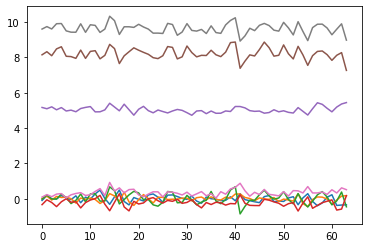

In [57]:
x_noisy1=x[xx]+np.random.normal(0,0.05,x[xx].shape)
plt.plot(x_noisy1[0])
print("")